## Screening Mammography Breast Cancer Detection
#### Grupo: Gabriel da Silva, Jhonatan Guilherme e Lílian Teixeira.

#### 1. Introdução
O intuito desse projeto é a criação de um modelo de Machine Learning que seja capaz de detectar se uma paciente possui ou não câncer de mama, baseado em uma mamografia. Para isso, utilizaremos o dataset [RSNA Screening Mammography Breast Cancer Detection](https://www.kaggle.com/competitions/rsna-breast-cancer-detection) disponibilizado pela **RSNA** (Radiological Society of North America) e hospedado no **Kaggle**.

O dataset é composto por 3 arquivos:
* **train.csv**: contém os dados de treino, com os IDs das imagens, a classificação (se a paciente possui ou não câncer de mama), entre outras características.
* **test.csv**: contém os dados de teste, com os IDs das imagens, entre outras características.
* **sample_submission.csv**: contém o ID das imagens e a probabilidade de a paciente possuir câncer de mama.

| site_id | patient_id | image_id | laterality | view | age | implant | machine_id | prediction_id |
| --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 1 | 1 | 1 | R | CC | 51 | N | 1 | 1 |
| 1 | 2 | 2 | R | CC | 62 | N | 1 | 2 |
| ... | ... | ... | ... | ... | ... | ... | ... | ... |

#### 2. Importação das bibliotecas

Para a realização desse projeto, utilizaremos as seguintes bibliotecas:

In [3]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np # linear algebra
import matplotlib.pyplot as plt # this is used for the plot the graph
import imageio.v3 as iio # this is used for image operation
import pydicom as dicom # for medical image analysis
import cv2 # for image processing
from PIL import Image # for image processing
import os # for path manipulation
import dicom2jpg # for converting dicom to jpg
import seaborn as sns # for data visualization
from pathlib import Path # for path manipulation
from sklearn import svm # for machine learning
from sklearn.model_selection import train_test_split # for splitting data into train and test

sns.set_style("darkgrid")
sns.set_color_codes("pastel")

#### 3. Importação dos dados

In [4]:
train_images_path = Path("data/train_images")

In [5]:
train_images = os.listdir("data/train_images")
test_images = os.listdir("data/test_images")
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")
# sample_submission_df = pd.read_csv("data/sample_submission.csv")

In [6]:
# Pegando a primeira imagem como exemplo (640805896.dcm)
example = train_images_path.__str__() + "/" + train_images[0]
dicom.dcmread(example)

Dataset.file_meta -------------------------------
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Digital X-Ray Image Storage - For Presentation
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.840.10009.1.2.3.5.1.1351088028
(0002, 0010) Transfer Syntax UID                 UI: JPEG 2000 Image Compression (Lossless Only)
(0002, 0012) Implementation Class UID            UI: 1.2.840.113654.2.3.1995.2.12.0
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 2.3.0'
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: 1.2.840.10009.1.2.3.5.1.1351088028
(0008, 0023) Content Date                        DA: '20221118'
(0008, 0033) Content Time                        TM: '184950.851185'
(0010, 0020) Patient ID                          LO: '5'
(0020, 000d) Study Instance UID                  UI: 1.2.840.10009.1.2.3.5
(0020, 000e) Series Instance UID            

#### 4. Análise exploratória dos dados

Os próximos passos são somente para teste:

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54706 entries, 0 to 54705
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   site_id                  54706 non-null  int64  
 1   patient_id               54706 non-null  int64  
 2   image_id                 54706 non-null  int64  
 3   laterality               54706 non-null  object 
 4   view                     54706 non-null  object 
 5   age                      54669 non-null  float64
 6   cancer                   54706 non-null  int64  
 7   biopsy                   54706 non-null  int64  
 8   invasive                 54706 non-null  int64  
 9   BIRADS                   26286 non-null  float64
 10  implant                  54706 non-null  int64  
 11  density                  29470 non-null  object 
 12  machine_id               54706 non-null  int64  
 13  difficult_negative_case  54706 non-null  bool   
dtypes: bool(1), float64(2)

As features **BIRADS** e **density** possui diversos valores nulos, por isso, iremos removê-la da predição de primeiro ponto.

<Axes: xlabel='cancer', ylabel='patient_id'>

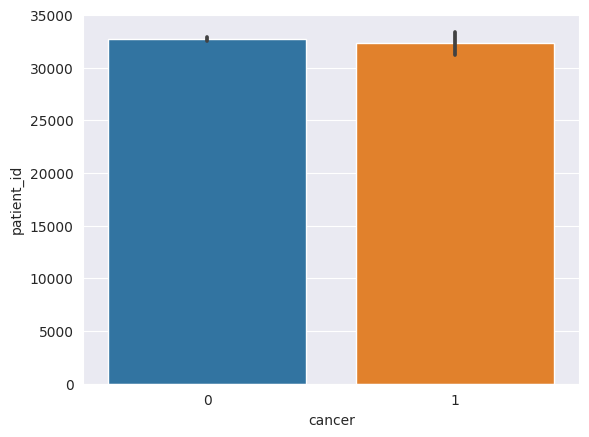

In [8]:
sns.barplot(train_df, x="cancer" , y="patient_id") # acho que esse gráfico não fez muito sentido, mas é isso por enquanto.

In [9]:
train_df

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54701,1,9973,1729524723,R,MLO,43.0,0,0,0,1.0,0,C,49,False
54702,1,9989,63473691,L,MLO,60.0,0,0,0,NaN,0,C,216,False
54703,1,9989,1078943060,L,CC,60.0,0,0,0,NaN,0,C,216,False
54704,1,9989,398038886,R,MLO,60.0,0,0,0,0.0,0,C,216,True


In [10]:
train_df.describe()

,site_id,patient_id,image_id,age,cancer,biopsy,invasive,BIRADS,implant,machine_id
count,54706.000000,54706.000000,5.470600e+04,54669.000000,54706.000000,54706.000000,54706.000000,26286.000000,54706.000000,54706.000000
mean,1.460407,32698.865262,1.079386e+09,58.543928,0.021168,0.054272,0.014953,0.772350,0.026999,54.618378
std,0.498434,18893.861534,6.183269e+08,10.050884,0.143944,0.226556,0.121365,0.590062,0.162081,44.784800
min,1.000000,5.000000,6.849100e+04,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21.000000
25%,1.000000,16481.000000,5.458153e+08,51.000000,0.000000,0.000000,0.000000,0.000000,0.000000,29.000000
50%,1.000000,32432.000000,1.082689e+09,59.000000,0.000000,0.000000,0.000000,1.000000,0.000000,49.000000
75%,2.000000,48999.000000,1.613228e+09,66.000000,0.000000,0.000000,0.000000,1.000000,0.000000,49.000000
max,2.000000,65534.000000,2.147472e+09,89.000000,1.000000,1.000000,1.000000,2.000000,1.000000,216.000000


In [11]:
test_image_ids = [image.split()[0] for image in train_images]
train_df.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True


In [12]:
for i in train_images_path.iterdir():
    print(i.__str__())

data/train_images/1351088028.dcm
data/train_images/1633417959.dcm
data/train_images/940388076.dcm
data/train_images/640805896.dcm


Caminho do arquivo: data/train_images/1351088028.dcm
Caminho do arquivo: data/train_images/1633417959.dcm
Caminho do arquivo: data/train_images/940388076.dcm
Caminho do arquivo: data/train_images/640805896.dcm


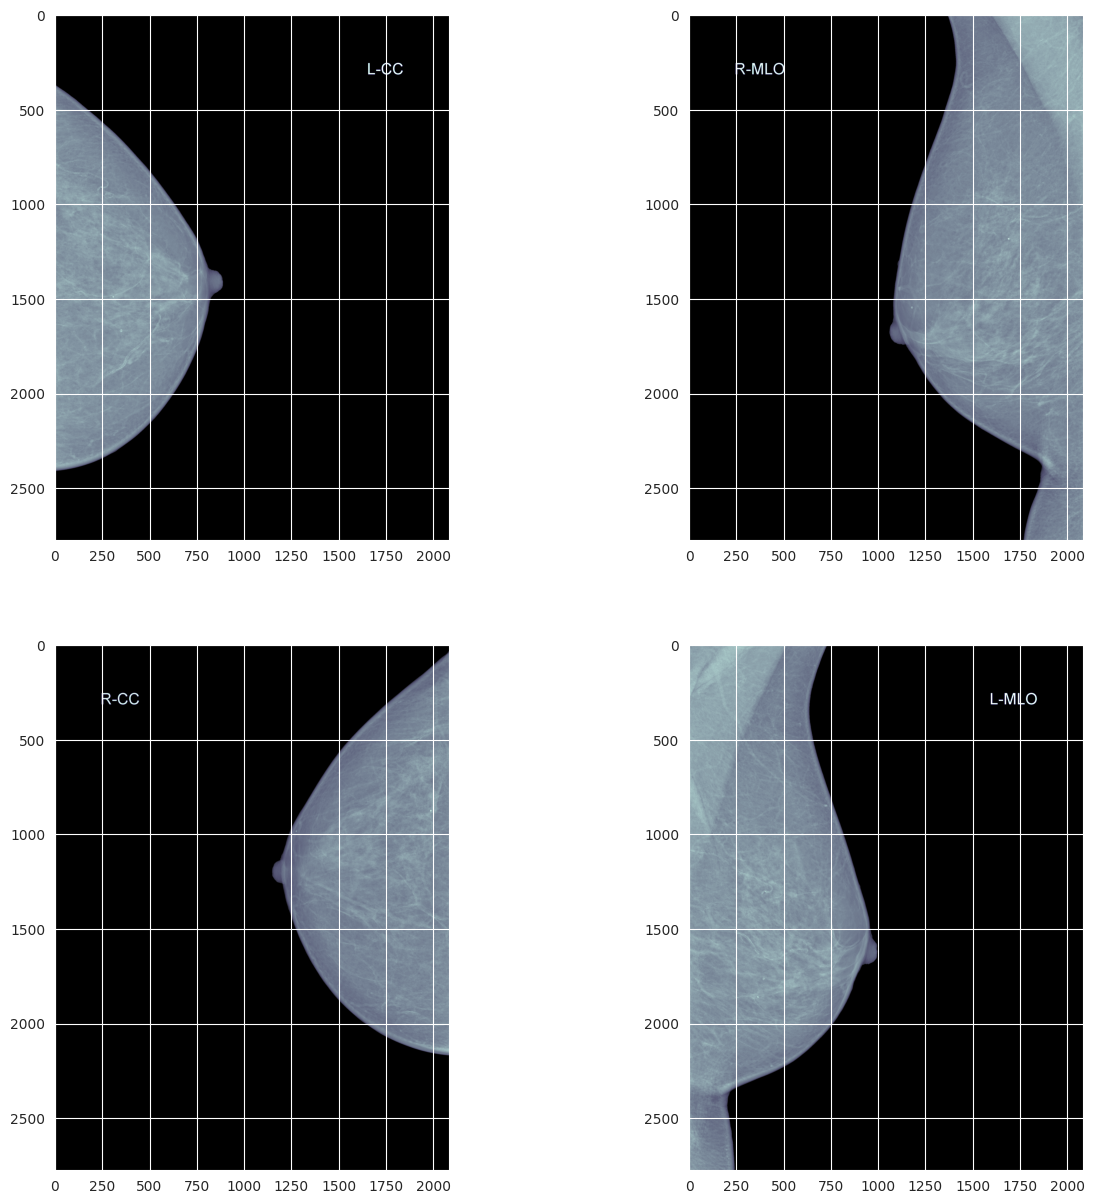

In [13]:
# TODO - Melhorar a visualização das imagens

fig, axs = plt.subplots(2, 2, figsize=(15,15))
axs = axs.flatten()

images_array = list()
patient_ids = list()
for n, image in enumerate(train_images_path.iterdir()):
    image_path = os.path.join(image)
    print(f"Caminho do arquivo: {image_path}")
    ds = dicom.dcmread(image_path)
    image_as_np = ds.pixel_array.astype(np.float32)
    # image_as_np = ds.convert_pixel_data("jpeg_ls")
    # image_as_np = image_as_np.astype(np.float32)
    images_array.append(image_as_np)
    patient_ids.append(ds.data_element("PatientID"))
    axs[n].imshow(image_as_np, cmap=plt.cm.bone)

In [14]:
images_array

[array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 array([[  0.,   0.,   0., ...,  96.,  93.,  95.],
        [  0.,   0.,   0., ...,  94.,  94.,  97.],
        [  0.,   0.,   0., ...,  95.,  96.,  96.],
        ...,
        [  0.,   0.,   0., ..., 101., 104., 103.],
        [  0.,   0.,   0., ...,  99.,  98.,  99.],
        [  0.,   0.,   0., ...,  98.,  98.,  98.]], dtype=float32),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 array([[ 98., 100., 100., ...,   0.,   0.,   0.],
        [ 96., 101., 100., ...,   0.,   0.,   0.],
        [ 99., 102., 101., ...,   

In [15]:
images_array[0].shape

(2776, 2082)

In [16]:
print(patient_ids)
print(patient_ids[0].value) # para acessar o valor do elemento

[(0010, 0020) Patient ID                          LO: '5', (0010, 0020) Patient ID                          LO: '5', (0010, 0020) Patient ID                          LO: '5', (0010, 0020) Patient ID                          LO: '5']
5


In [17]:
# não seguir por esse caminho, porque o dicom2jpg salva os arquivos, precisamos fazer o processamento em memória.
# dicom2jpg.dicom2jpg(dcm_folder_path, target_root=jpg_folder_path)

#### 5. Pré-processamento dos dados

In [18]:
from skimage.transform import resize

In [19]:
example_rows = train_df[train_df["patient_id"].isin([int(id.value) for id in patient_ids])]
example_rows = example_rows.sort_values("image_id")
example_rows

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
37282,2,5,640805896,L,MLO,68.0,0,0,0,0.0,0,NaN,21,True
37284,2,5,940388076,R,CC,68.0,0,0,0,NaN,0,NaN,21,False
37283,2,5,1351088028,L,CC,68.0,0,0,0,0.0,0,NaN,21,True
37285,2,5,1633417959,R,MLO,68.0,0,0,0,NaN,0,NaN,21,False


In [57]:
images_array = [np.array(image_array.flatten(), dtype="object") for image_array in images_array]
type(images_array[0])

numpy.ndarray

In [58]:
example_rows["image_as_array"] = images_array
example_rows

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,image_as_array
37282,2,5,640805896,L,MLO,68.0,0,0,0,0.0,0,NaN,21,True,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
37284,2,5,940388076,R,CC,68.0,0,0,0,NaN,0,NaN,21,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
37283,2,5,1351088028,L,CC,68.0,0,0,0,0.0,0,NaN,21,True,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
37285,2,5,1633417959,R,MLO,68.0,0,0,0,NaN,0,NaN,21,False,"[98.0, 100.0, 100.0, 100.0, 99.0, 99.0, 99.0, ..."


#### 6. Modelagem

In [59]:
X = example_rows["image_as_array"] # features
y = example_rows["cancer"] # target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=101)

In [26]:
# aparentemente não é possível usar a feature age como está, ela não é um array como o image_as_array
# image_shape = X_train.iloc[1]["image_as_array"].shape
# print(image_shape[0])

# X_train["age"] = [[age] + np.zeros(image_shape[0] - 1) for age in list(X_train["age"])]
# X_train

In [27]:
# aparentemente não é possível usar a feature age como está, ela não é um array como o image_as_array
# image_shape = X_test.iloc[0]["image_as_array"].shape
# print(image_shape[0])

# X_test["age"] = [[age] + np.zeros(image_shape[0] - 1) for age in list(X_test["age"])]
# X_test

In [60]:
X_train

37282    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
37284    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
37285    [98.0, 100.0, 100.0, 100.0, 99.0, 99.0, 99.0, ...
Name: image_as_array, dtype: object

In [61]:
X_train.iloc[2].shape

(5779632,)

In [62]:
y_train

37282    0
37284    0
37285    0
Name: cancer, dtype: int64

In [63]:
X_test.iloc[0].shape

(5779632,)

In [64]:
y_test

37283    0
Name: cancer, dtype: int64

In [65]:
from sklearn import svm

In [66]:
clf = svm.LinearSVC(C=10)
clf.fit(X_train, y_train)

ValueError: setting an array element with a sequence.

In [ ]:
# why ValueError: setting an array element with a sequence. error is happening? this is happening because 
# 


In [ ]:
from sklearn.metrics import accuracy_score

# generate predictions
y_pred = clf.predict(X_test)

# calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Model accuracy is: ', accuracy)